# CNN + extras
* 이미지 픽셀 정보는 CNN이 학습, 이미지에 대한 부수적인 정보(비율, 면적)는 FC에서 학습

In [ ]:
# Dataset 클래스
from torch.utils.data import Dataset
from PIL import Image, ImageOps

class CarrotDatasetWithSize(Dataset):
    def __init__(self, root_dir, label_map, transform=None):
        self.samples = []           # 파일 경로와 라벨을 짝지어 리스트에 저장
        self.transform = transform
        self.label_map = label_map

        # samples 리스트에 이미지파일 경로와 라벨을 모두 저장
        for class_name, label in label_map.items():   # {'cat': 0, 'dog': 1}
            class_path = os.path.join(root_dir, class_name)
            for fname in os.listdir(class_path):
                if fname.lower().endswith(('.jpg', '.png')):
                    self.samples.append((os.path.join(class_path, fname), label))  # (이미지 파일 경로, 0/1)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        # 원본 이미지 크기 정보
        orig_w, orig_h = image.size
        area = orig_w * orig_h
        aspect_ratio = orig_w / orig_h
        size_features = torch.tensor([orig_w, orig_h, area, aspect_ratio], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, size_features, label   # 이미지, 크기, 라벨 리턴


In [ ]:
# CNN
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# 신경망을 정의할 때는 Batch 크기를 고려하지 않지만 Tensor 연산은 배치단위 병렬처리가 기본임
# 신경망에 데이터를 전달할 때는 Batch 단위로 전달해야 하며 신경망 출력측에서도 배치단위로 출력된다
# 개발자는 하나의 샘플을 기준으로 신경망 구조만 정의하면 되며,
# 여러 샘플을 병렬로 처리하는 역할은 프레임워크(Pytorch, TensorFlow)가 자동으로 수행한다.
class SimpleCNNWithSize(nn.Module):
    def __init__(self):
        super().__init__()    # 신경망을 선언할 때는 Batch 크기를 고려하지 않으며 Tensor연산은 배치단위 병렬처리를 지원함
        self.conv = nn.Sequential(  # 3channel, 16filters, filter-size 3
            nn.Conv2d(3, 16, 3, padding=1),  # 128x128x3 -> 128x128x16, padding=1은 1픽셀 추가하여 출력크기 유지
            nn.ReLU(),
            nn.MaxPool2d(2),        # -> 64x64x16, 이미지 크기를 1/2로 축소(국소적 특징 요약)
            nn.Conv2d(16, 32, 3, padding=1), # 64x64x16 -> 64x64x32
            nn.ReLU(),
            nn.MaxPool2d(2),     # -> 32x32x32
        )
        self.flat_size = 32 * 32 * 32
        self.fc = nn.Sequential(
            nn.Linear(self.flat_size + 4, 128),  # +4 for size info
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x, size_feats):    # 순전파(forward) 정의
        x = self.conv(x)                        # x: (B, 32, 32, 32)
        x = x.view(x.size(0), -1)  # Flatten    # x: (B, 32768)  1차원 데이터가 Batch 만큼 리턴됨. -1은 자동으로 설정
        x = torch.cat([x, size_feats], dim=1)   # 각 배치에 이미지 사이즈 정보 추가. 2번째 차원에 추가
        return self.fc(x)


In [ ]:
# DataLoader 생성
transform = transforms.Compose([
    transforms.Resize((128, 128)),      # 이미지를 고정 크기로 설정
    transforms.ToTensor(),              # 이미지를 PyTorch 텐서로 변환
    transforms.Normalize([0.5], [0.5])  # 빠르고 안정적인 학습을 위한 정규화(0~1 -> -1~1), (x-0.5)/0.5
])

data_path = "/content/drive/MyDrive/Python_AI/CNN/dataset"
BATCH_SIZE = 4
label_map = {'cat': 0, 'dog': 1}  # class_names = ['cat', 'dog']
train_dataset = CarrotDatasetWithSize(data_path + '/train', label_map, transform=transform)
valid_dataset = CarrotDatasetWithSize(data_path + '/val', label_map, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = list(label_map.keys())  # ['cat', 'dog']

In [ ]:
# 학습 루프
BATCH_SIZE = 4
EPOCHS = 100
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE=", DEVICE)

model = SimpleCNNWithSize().to(DEVICE)   # 모델 생성 및 GPU에 이동
criterion = nn.CrossEntropyLoss()        # Softmax 포함
optimizer = optim.Adam(model.parameters(), lr=LR)

train_acc_list, val_acc_list = [], []

for epoch in range(EPOCHS):
    model.train()
    correct, total, loss_total = 0, 0, 0
    for x, size_feats, y in train_loader:   # Batch 단위 로드
        x, y, size_feats = x.to(DEVICE), y.to(DEVICE), size_feats.to(DEVICE)   # image, label, size_feats GPU에 이동
        optimizer.zero_grad()
        outputs = model(x, size_feats)   # __call__() -> forward()
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
        correct += (outputs.argmax(1) == y).sum().item()
        total += y.size(0)    # 라벨의 Batch 샘플 수. 총 샘플 수 합산
    train_acc = correct / total
    train_acc_list.append(train_acc)   # epoch 정확도 리스트에 저장

    # 검증
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, size_feats, y in valid_loader:
            x, y, size_feats = x.to(DEVICE), y.to(DEVICE), size_feats.to(DEVICE)   #
            outputs = model(x, size_feats)   # GPU에서 작동하는 모델이 리턴하는 값과 연산하는 대상 데이터도 GPU에 존재해야 한다
            correct += (outputs.argmax(1) == y).sum().item()   # GPU에서 리턴된 값과 연산하는 대상 데이터 y
            total += y.size(0)
    val_acc = correct / total
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1} | Loss: {loss_total:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


DEVICE= cpu
Epoch 1 | Loss: 953.4419 | Train Acc: 0.5435 | Val Acc: 0.5000
Epoch 2 | Loss: 767.3822 | Train Acc: 0.4891 | Val Acc: 0.5000
Epoch 3 | Loss: 675.9675 | Train Acc: 0.5000 | Val Acc: 0.5000
Epoch 4 | Loss: 207.1654 | Train Acc: 0.4565 | Val Acc: 0.5000
Epoch 5 | Loss: 291.2348 | Train Acc: 0.5000 | Val Acc: 0.4000
Epoch 6 | Loss: 149.5034 | Train Acc: 0.5326 | Val Acc: 0.6000
Epoch 7 | Loss: 169.7136 | Train Acc: 0.5870 | Val Acc: 0.4000
Epoch 8 | Loss: 176.5778 | Train Acc: 0.6196 | Val Acc: 0.4000
Epoch 9 | Loss: 122.7208 | Train Acc: 0.7174 | Val Acc: 0.7000
Epoch 10 | Loss: 55.5184 | Train Acc: 0.7826 | Val Acc: 0.6000
Epoch 11 | Loss: 12.9349 | Train Acc: 0.9130 | Val Acc: 0.7000
Epoch 12 | Loss: 51.9807 | Train Acc: 0.7935 | Val Acc: 0.5000
Epoch 13 | Loss: 98.6889 | Train Acc: 0.7500 | Val Acc: 0.6000
Epoch 14 | Loss: 42.6414 | Train Acc: 0.8261 | Val Acc: 0.7000
Epoch 15 | Loss: 2.1554 | Train Acc: 0.9891 | Val Acc: 0.5000
Epoch 16 | Loss: 3.0630 | Train Acc: 0.9674 

In [ ]:
# 추론
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")  # 흑백, RGBA, BGR 등을 RGB 3채널로 변환해야만 신경망에서 설정한 3채널과 일치함
    orig_w, orig_h = image.size
    area = orig_w * orig_h
    aspect_ratio = orig_w / orig_h    # 이미지 크기 정보 생성 및 GPU에 이동
    size_feat = torch.tensor([[orig_w, orig_h, area, aspect_ratio]], dtype=torch.float32).to(DEVICE)

    image_tensor = transform(image).unsqueeze(0).to(DEVICE)   # 이미지 1개를 Batch 형식의 차원으로 변환하여 GPU에 이동
    output = model(image_tensor, size_feat)    # __call__() -> forward() 순전파
    pred = output.argmax(dim=1).item()    # (Batch, classes) 차원의 2번째인 classes에서 가장 큰 값의 인덱스 리턴

    plt.imshow(np.array(image))
    plt.title(f"Prediction: {class_names[pred]}")
    plt.axis('off')
    plt.show()


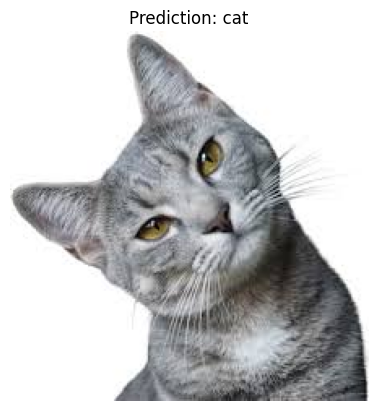

In [ ]:
predict_image('/content/drive/MyDrive/Python_AI/CNN/dataset/test/cat1.jpg')